In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet34
from torchvision.models.resnet import ResNet34_Weights
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from PIL import Image

In [2]:
# Data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean and std
])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean and std
])

val_test_transforms = data_transforms

In [3]:
# Load dataset
data_folder = 'data'
dataset = ImageFolder(root=data_folder)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Epoch 1/10
Train Loss: 0.9404, Train Accuracy: 59.00%
Validation Loss: 0.7607, Validation Accuracy: 76.44%

Epoch 2/10
Train Loss: 0.6959, Train Accuracy: 76.86%
Validation Loss: 0.6074, Validation Accuracy: 83.56%

Epoch 3/10
Train Loss: 0.5801, Train Accuracy: 83.86%
Validation Loss: 0.5187, Validation Accuracy: 86.89%

Epoch 4/10
Train Loss: 0.5126, Train Accuracy: 85.19%
Validation Loss: 0.4638, Validation Accuracy: 87.56%

Epoch 5/10
Train Loss: 0.4655, Train Accuracy: 87.10%
Validation Loss: 0.4245, Validation Accuracy: 88.44%

Epoch 6/10
Train Loss: 0.4196, Train Accuracy: 88.43%
Validation Loss: 0.3934, Validation Accuracy: 89.33%

Epoch 7/10
Train Loss: 0.4008, Train Accuracy: 88.33%
Validation Loss: 0.3726, Validation Accuracy: 89.56%

Epoch 8/10
Train Loss: 0.3663, Train Accuracy: 90.19%
Validation Loss: 0.3536, Validation Accuracy: 91.11%

Epoch 9/10
Train Loss: 0.3504, Train Accuracy: 90.33%
Validation Loss: 0.3359, Validation Accuracy: 90.00%

Epoch 10/10
Train Loss: 0.33

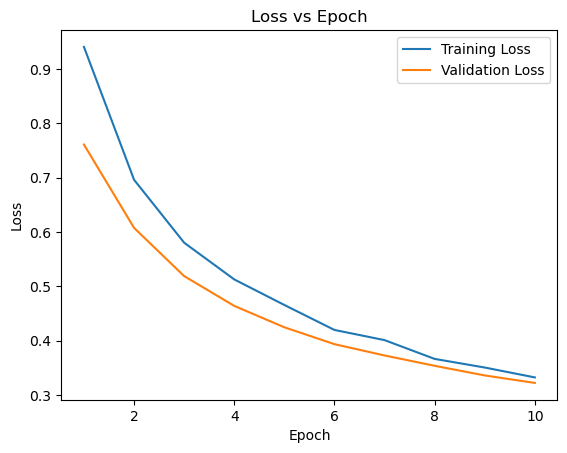

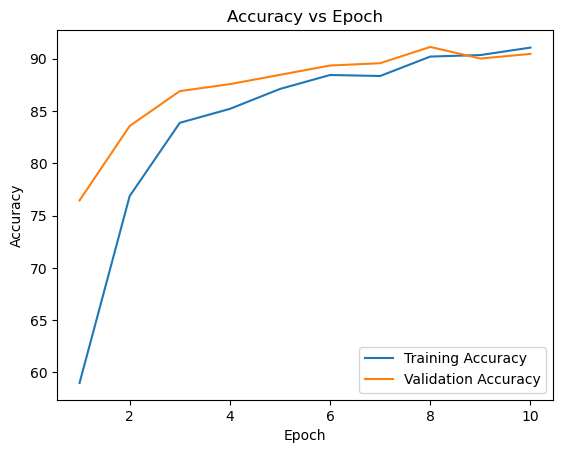

In [4]:
# All layers frozen except the fully connected classifier layer
num_classes = 3
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.SGD(model.fc.parameters(), lr=1e-4, momentum=0.9)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    print()
    
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.plot(range(1, num_epochs+1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

Epoch 1/10
Train Loss: 0.3169, Train Accuracy: 91.43%
Validation Loss: 0.3181, Validation Accuracy: 90.44%

Epoch 2/10
Train Loss: 0.3212, Train Accuracy: 91.29%
Validation Loss: 0.3098, Validation Accuracy: 90.67%

Epoch 3/10
Train Loss: 0.3185, Train Accuracy: 90.76%
Validation Loss: 0.3011, Validation Accuracy: 90.89%

Epoch 4/10
Train Loss: 0.3018, Train Accuracy: 91.67%
Validation Loss: 0.2928, Validation Accuracy: 91.56%

Epoch 5/10
Train Loss: 0.3029, Train Accuracy: 91.19%
Validation Loss: 0.2863, Validation Accuracy: 90.89%

Epoch 6/10
Train Loss: 0.2935, Train Accuracy: 91.48%
Validation Loss: 0.2830, Validation Accuracy: 91.78%

Epoch 7/10
Train Loss: 0.2858, Train Accuracy: 92.05%
Validation Loss: 0.2759, Validation Accuracy: 91.33%

Epoch 8/10
Train Loss: 0.2730, Train Accuracy: 92.29%
Validation Loss: 0.2683, Validation Accuracy: 91.33%

Epoch 9/10
Train Loss: 0.2778, Train Accuracy: 92.33%
Validation Loss: 0.2695, Validation Accuracy: 91.56%

Epoch 10/10
Train Loss: 0.26

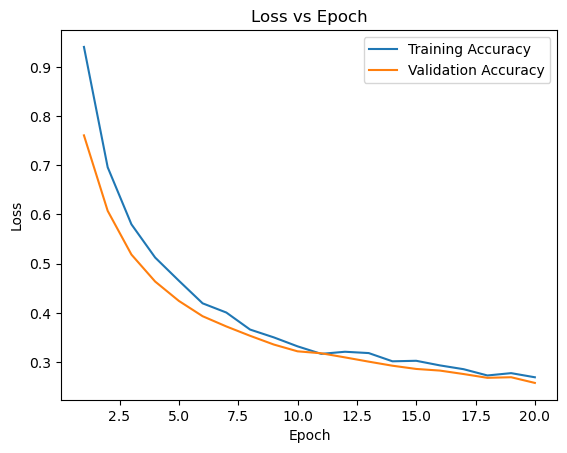

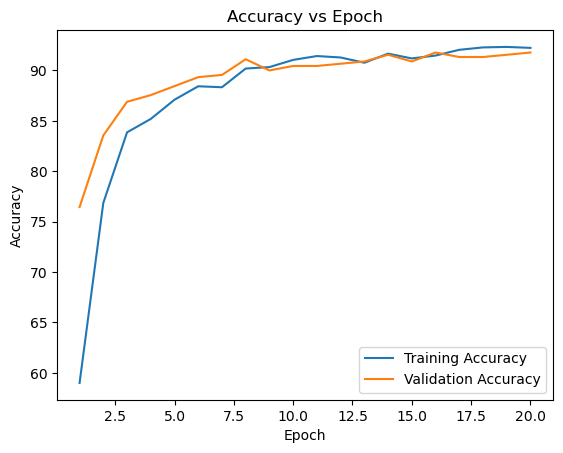

In [5]:
# The next layer is unfrozen after 10 epochs
for param in model.layer4.parameters():
    param.requires_grad = True

optimizer = optim.SGD([
    {'params': model.layer4.parameters()},
    {'params': model.fc.parameters()}], lr=1e-5, momentum=0.9)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy) 
    
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    print()
    
plt.plot(range(1,21), train_losses, label="Training Accuracy")
plt.plot(range(1,21) , val_losses, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.plot(range(1, 21), train_accuracies, label="Training Accuracy")
plt.plot(range(1, 21), val_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()
    

Epoch 1/10
Train Loss: 0.2544, Train Accuracy: 93.19%
Validation Loss: 0.2576, Validation Accuracy: 92.00%

Epoch 2/10
Train Loss: 0.2603, Train Accuracy: 92.71%
Validation Loss: 0.2559, Validation Accuracy: 92.00%

Epoch 3/10
Train Loss: 0.2596, Train Accuracy: 92.76%
Validation Loss: 0.2583, Validation Accuracy: 91.78%

Epoch 4/10
Train Loss: 0.2577, Train Accuracy: 93.00%
Validation Loss: 0.2517, Validation Accuracy: 92.00%

Epoch 5/10
Train Loss: 0.2522, Train Accuracy: 93.29%
Validation Loss: 0.2542, Validation Accuracy: 91.78%

Epoch 6/10
Train Loss: 0.2655, Train Accuracy: 92.10%
Validation Loss: 0.2512, Validation Accuracy: 92.00%

Epoch 7/10
Train Loss: 0.2540, Train Accuracy: 93.33%
Validation Loss: 0.2501, Validation Accuracy: 92.00%

Epoch 8/10
Train Loss: 0.2492, Train Accuracy: 93.29%
Validation Loss: 0.2521, Validation Accuracy: 92.22%

Epoch 9/10
Train Loss: 0.2448, Train Accuracy: 93.38%
Validation Loss: 0.2461, Validation Accuracy: 92.22%

Epoch 10/10
Train Loss: 0.24

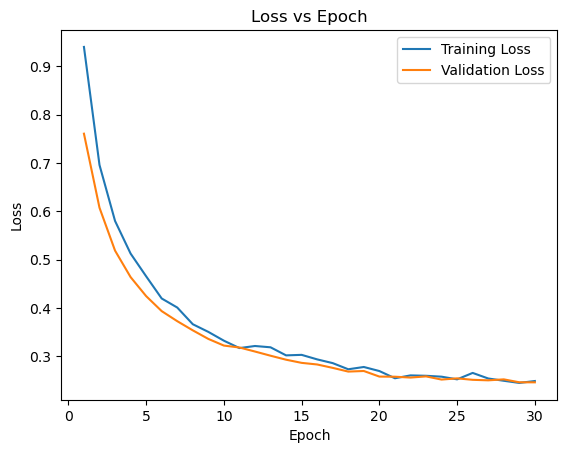

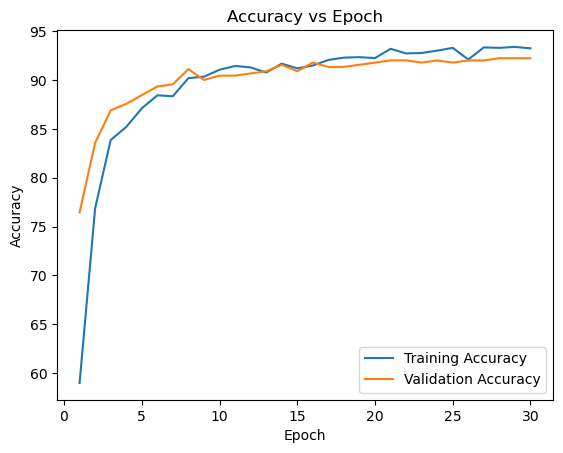

In [6]:
# The next layer is unfrozen after another 10 epochs
for param in model.layer3.parameters():
    param.requires_grad = True

optimizer = optim.SGD([
    {'params': model.layer3.parameters(), 'lr': 1e-6},
    {'params': model.layer4.parameters(), 'lr': 1e-6},
    {'params': model.fc.parameters(), 'lr': 1e-6},
], momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy) 
    
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    print()

torch.save(model, 'model.pt')
    
plt.plot(range(1, 31), train_losses, label="Training Loss")
plt.plot(range(1, 31), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.plot(range(1, 31), train_accuracies, label="Training Accuracy")
plt.plot(range(1, 31), val_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()


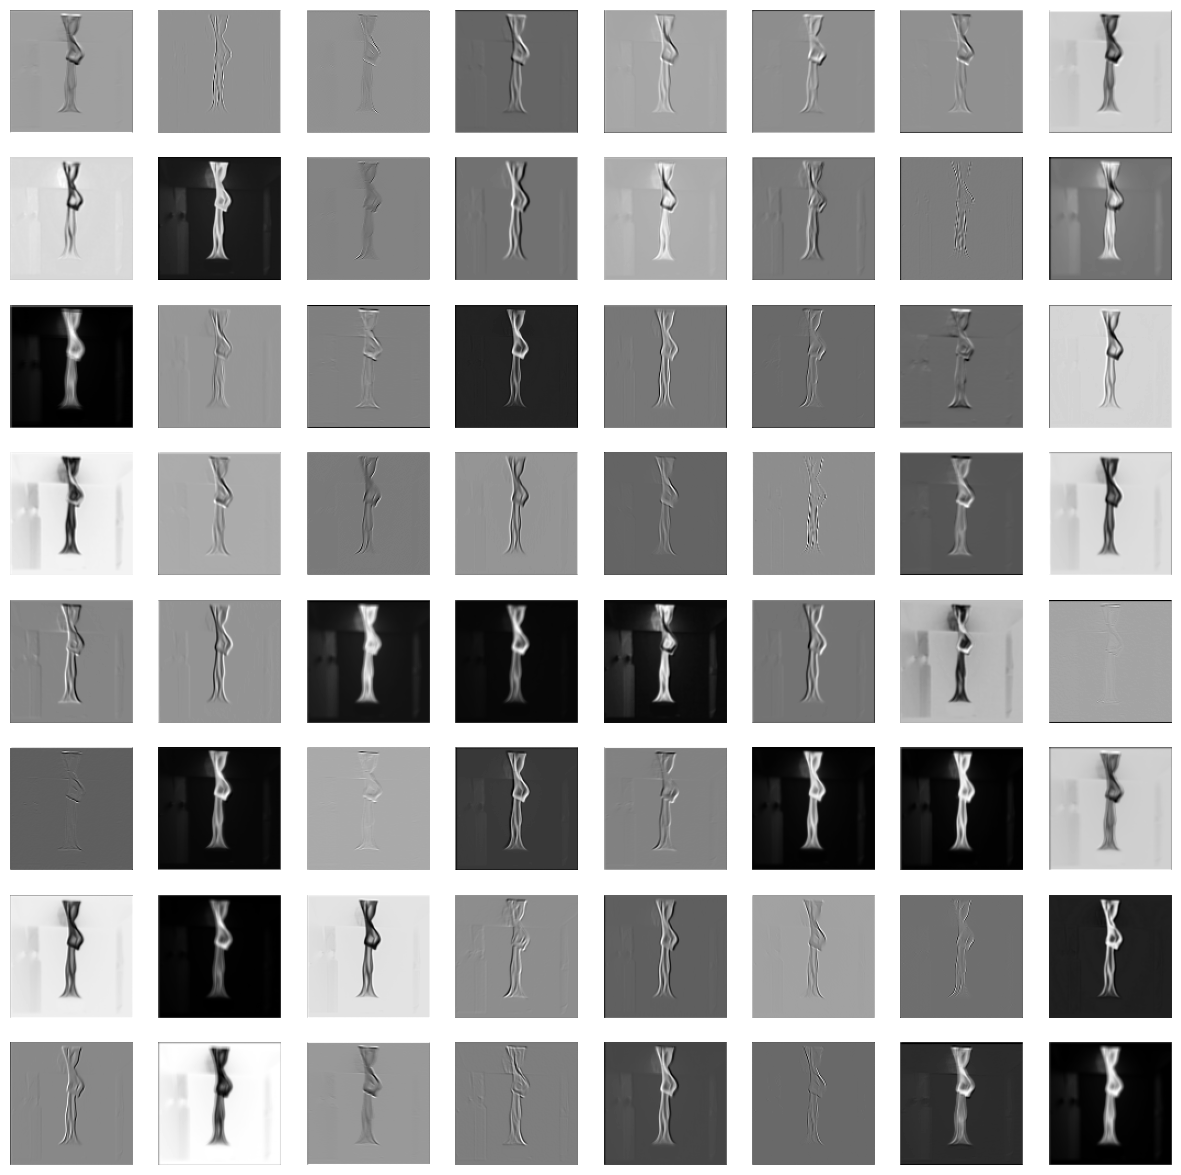

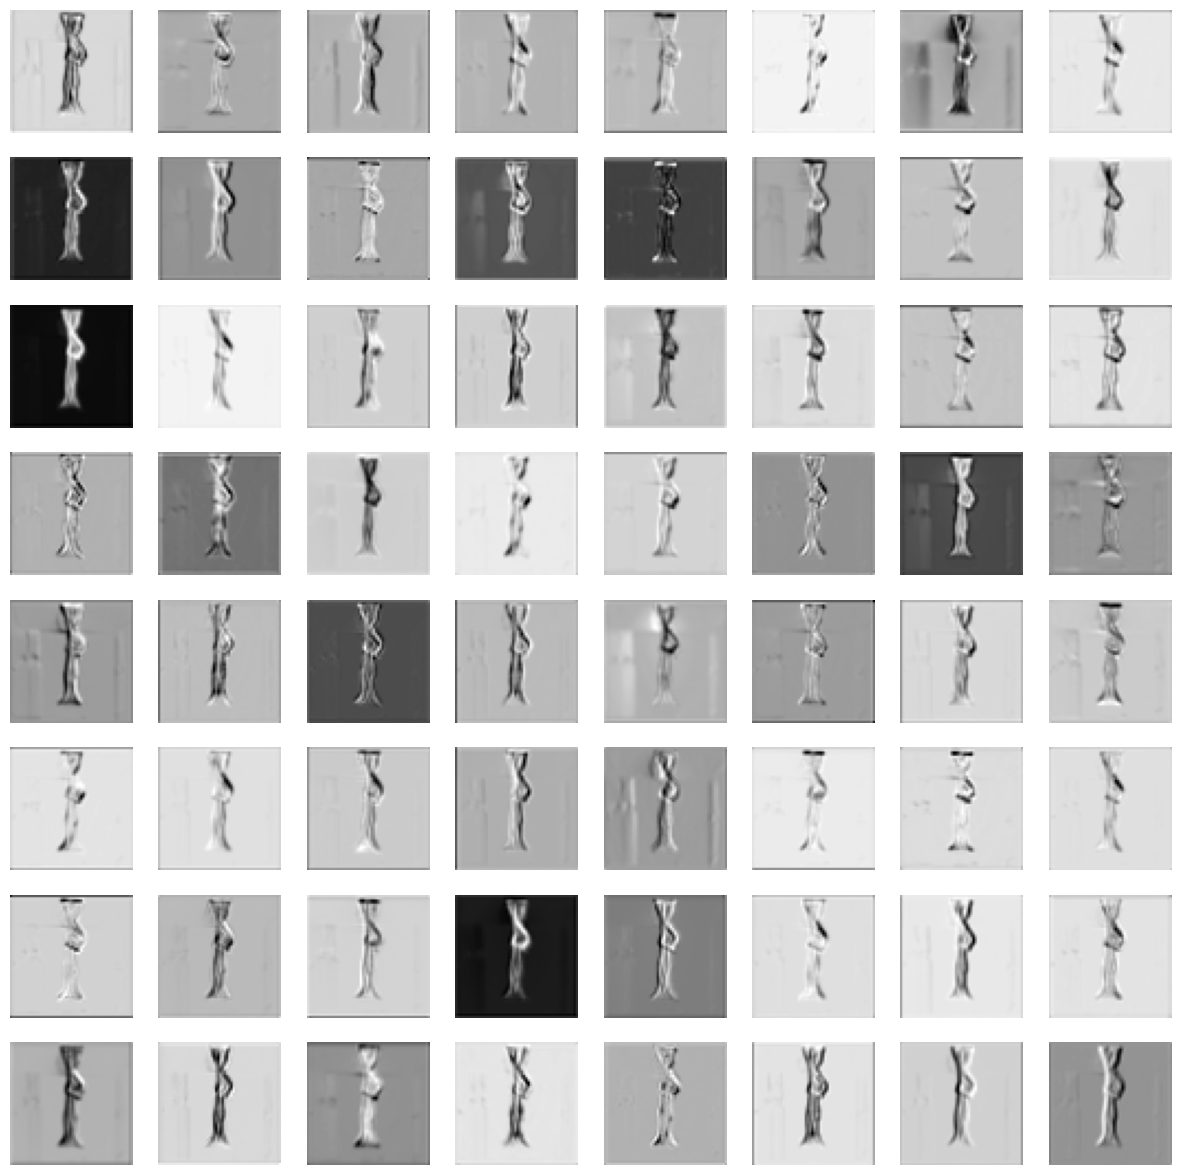

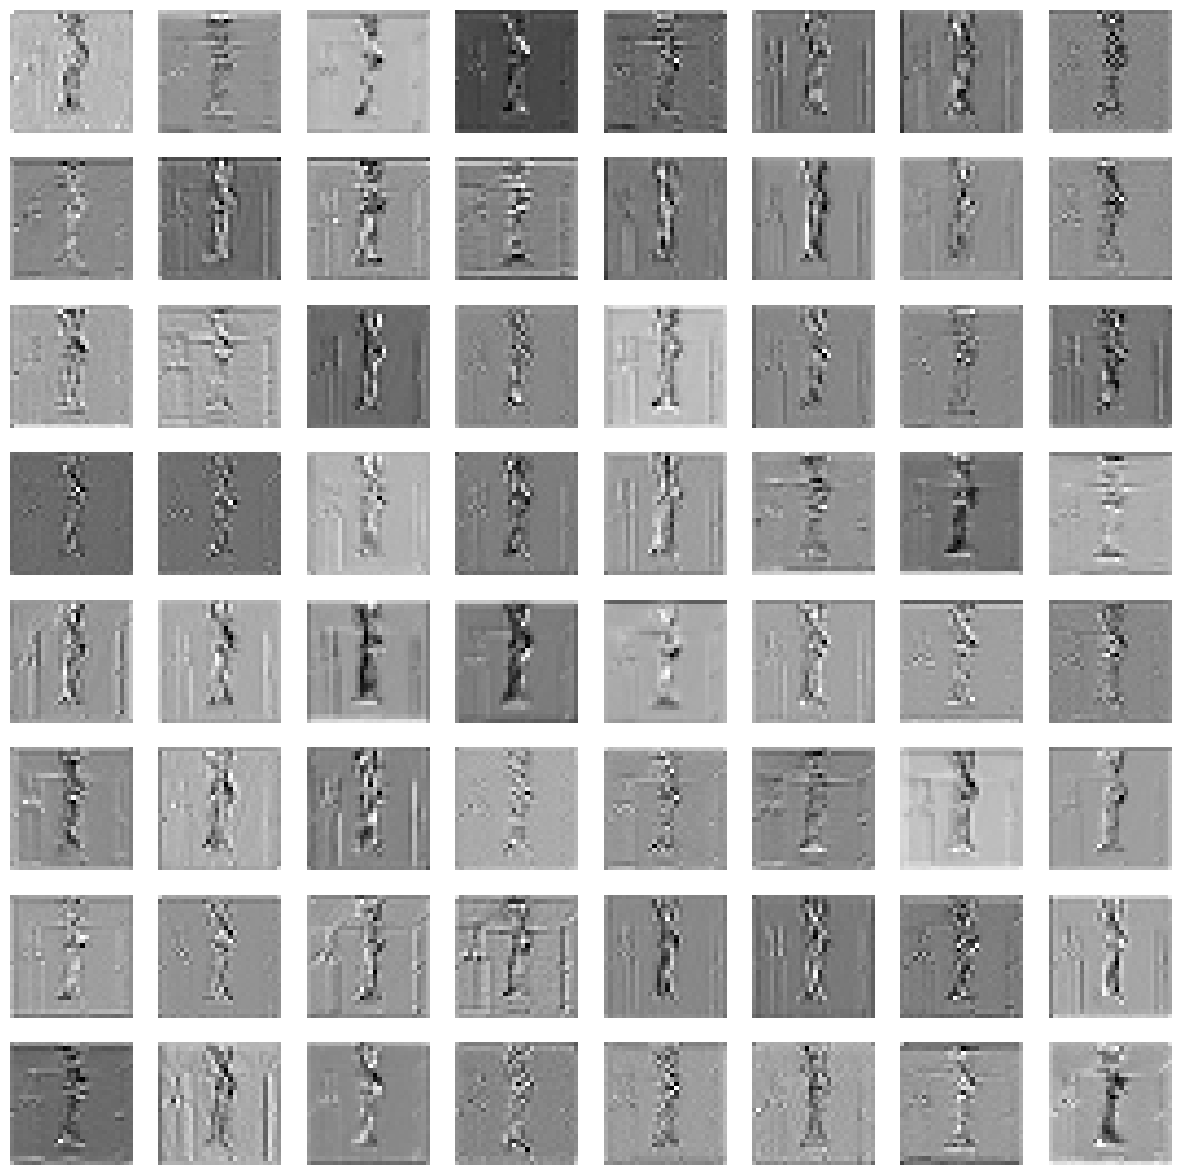

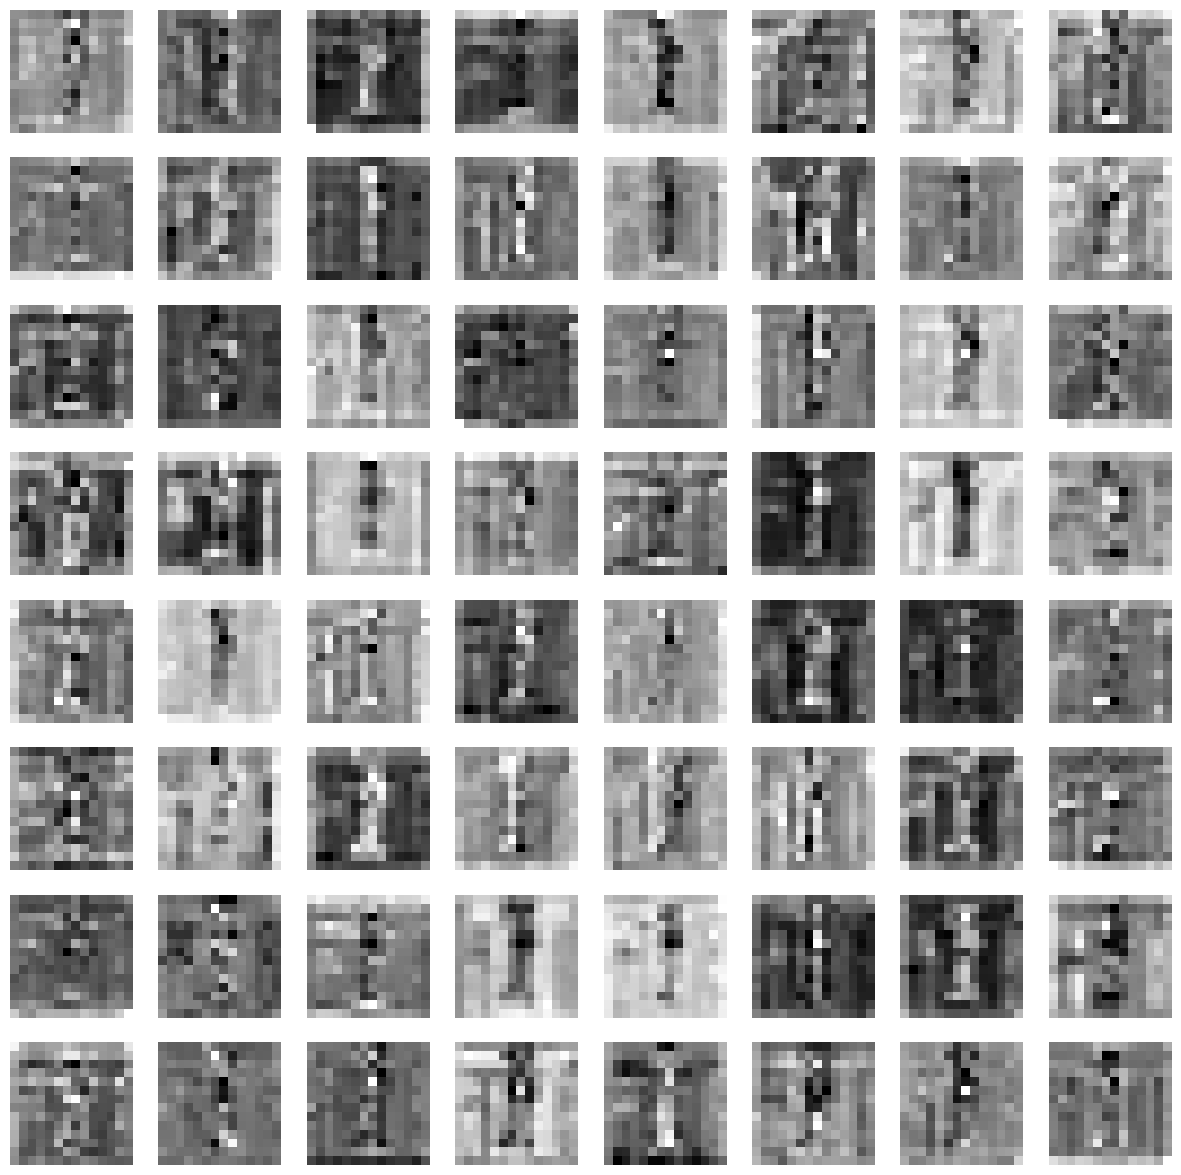

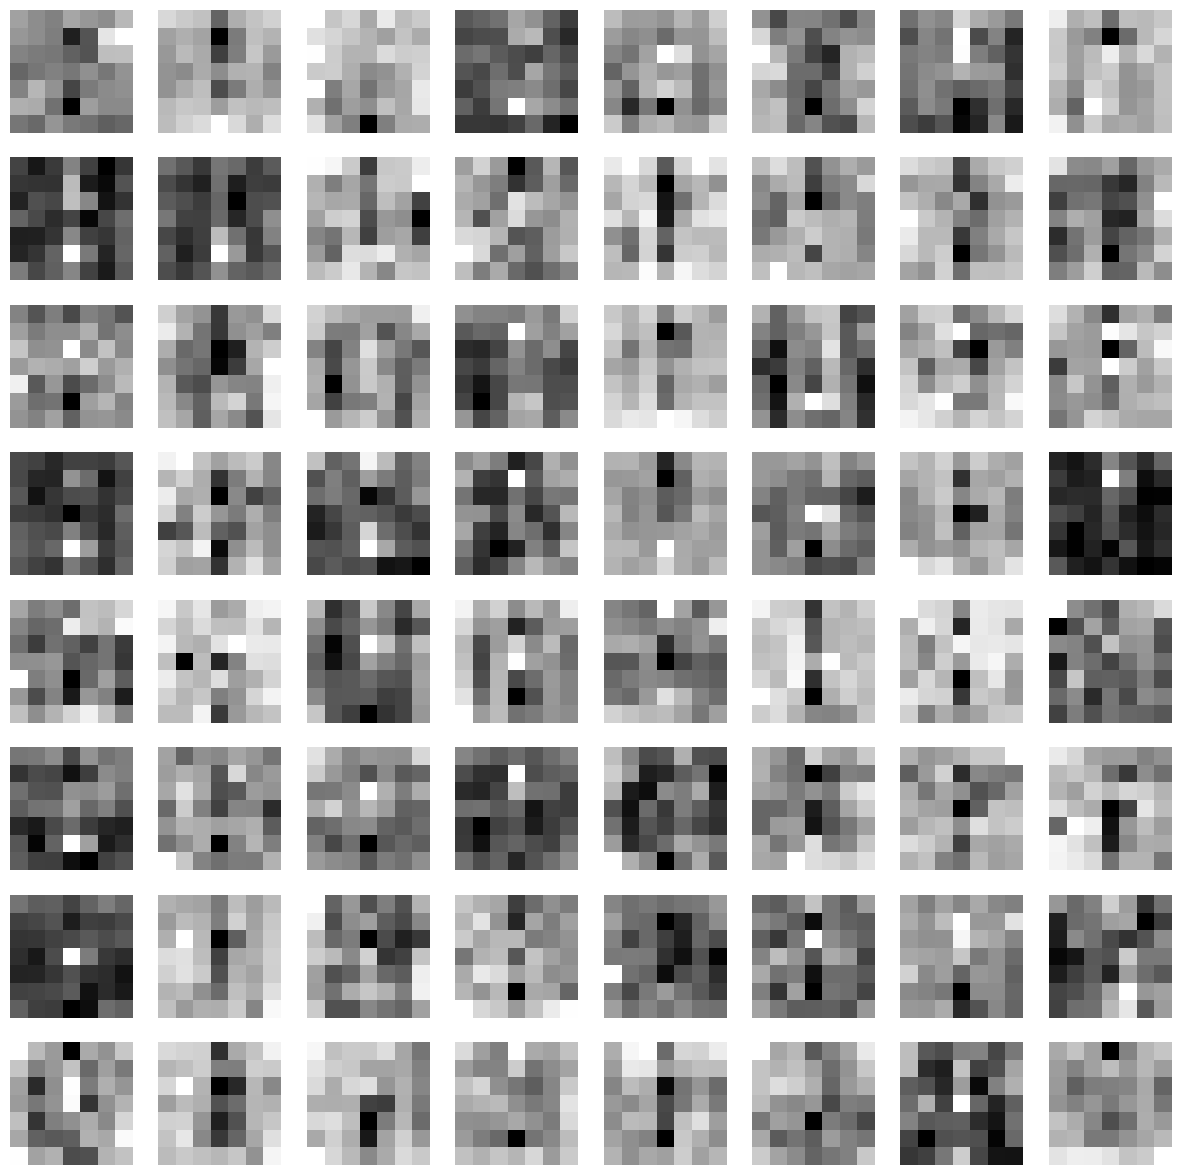

In [7]:
# visualize hook
model = torch.load("model.pt")
def visualize_hook(module, input, output):
    num_maps = min(output.size(1), 64)
    plt.figure(figsize=(15, 15))
    for i in range(num_maps):
        plt.subplot(8, 8, i + 1)
        plt.imshow(output[0, i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()

layer_to_visualize = model.conv1
hook = layer_to_visualize.register_forward_hook(visualize_hook)

image_path = "pentane_feature_map.JPG"
image = Image.open(image_path)
image = val_test_transforms(image)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image = image.to(device)
image = image.unsqueeze(0)
model.to(device)
output = model(image)

hook.remove()

layers_to_visualize = [model.layer1[0].conv1, model.layer2[0].conv1, model.layer3[0].conv1, model.layer4[0].conv1]

for layer_to_visualize in layers_to_visualize:
    hook = layer_to_visualize.register_forward_hook(visualize_hook)
    _ = model(image)
    hook.remove()